# Modele Seq2Seq i atencja
Poniższy notebook jest inspirowany tym tutorialem PyTorcha: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html. 

W tym notebooku będziemy próbować rozwiązać problem automatycznego tłumaczenia zdań z jednego języka naturalnego na drugi -- konkretniej z języka polskiego na angielski. Dla przykładu model otrzymujący zdanie:

> Myślę, że mnie okłamałeś

Powinien zwrócić zdanie
> I think you lied to me.

# Importy i przygotowanie danych
Poniżej znajdują się importy bibliotek potrzebnych do rozwiązania problemu a także skrypt do ładowania zbioru danych zawierającego pary zdań w języku polskim i angielskim. Model przedstawione w tym rozdziale wymagają dużej mocy obliczeniowej, w związku z czym zachęcamy do korzystania z karty graficznej i CUDA.

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import string
import numpy as np
import re
import random
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchtext.data.metrics import bleu_score

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Pobieranie zbioru danych. Dataset pochodzi ze strony [tatoeba.org](https://tatoeba.org/en/downloads) i został udostępniony na podstawie licencji [CC BY 2.0 FR](https://creativecommons.org/licenses/by/2.0/fr/deed.en).

In [3]:
!wget https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/eng-pol.txt

--2022-04-10 00:18:30--  https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/eng-pol.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5081049 (4.8M) [text/plain]
Saving to: ‘eng-pol.txt’

eng-pol.txt         100%[===================>]   4.84M  8.64MB/s    in 0.6s    

2022-04-10 00:18:32 (8.64 MB/s) - ‘eng-pol.txt’ saved [5081049/5081049]



Poniżej przygotowujemy klasę `Lang` która będzie służyła jako struktura do obsługiwania naszego języka (osobna dla angielskiego i polskiego w naszym przypadku). Do każdego słowa w języku przypisujemy indeks (liczbę porządkową identyfikującą słowo). Dodatkowo definiujemy trzy dodatkowe indeksy:

* 0 dla początku zdania (Start of Sentence, SOS)
* 1 dla końca zdania (End of Sentence, EOS)
* 2 dla paddingu ("pustych" wartości). Wartościami tymi będziemy wypełniać zdania w batchu tak, żeby wszystkie były równej długości -- dzięki temu łatwiej będzie zrównoleglić przetwarzanie ich na GPU.

In [4]:
SOS_token = 0
EOS_token = 1
PAD_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "PAD"}
        self.n_words = 3  # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Funkcje do normalizowania wchodzących zdań - zamieniamy Unicode na ASCII, zamieniamy wszystkie wielkie litery na małe itd.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = s.replace("ł", "l")
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open("eng-pol.txt", encoding="utf-8").read().strip().split("\n")
    lines = lines[1:]  # Skip first line with attributions.

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split("\t")[1::2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Wyrzućmy zdania które są zbyt długie (ponad 20 słów).

In [6]:
MAX_LENGTH = 20


def filterPair(p):
    return len(p[0].split(" ")) <= MAX_LENGTH and len(p[1].split(" ")) <= MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Pełny proces przetwarzania danych wygląda następująco:

- Wczytujemy plik z danymi, dzielimy go na pary zdań.
- Normalizujemy tekst
- Zamieniamy zdania w listy słów.




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print(pairs[0])
    print(f"Read {len(pairs)} sentence pairs")
    pairs = filterPairs(pairs)
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("pol", "eng", True)
print("Przykładowe pary zdań:")
for _ in range(3):
    print(random.choice(pairs))

Reading lines...
['sprobujmy cos .', 'let s try something .']
Read 59749 sentence pairs
Trimmed to 59404 sentence pairs
Counting words...
Counted words:
eng 29246
pol 11953
Przykładowe pary zdań:
['uwazam ze tom jest twardy .', 'i think that tom is tough .']
['mysle ze to jest w porzadku .', 'it may be all right .']
['to moj pierwszy lot samolotem .', 'that was the first time i got on a plane .']


Na koniec definiujemy jeszcze funkcje, które pozwolą nam zamienić zdania w tensory, które nasza sieć będzie w stanie zrozumieć.

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(" ")]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


def pad_sequences(data_batch):
    pl_batch, en_batch = [], []
    for pl_sentence, en_sentence in data_batch:
        pl_batch += [pl_sentence]
        en_batch += [en_sentence]
    pl_batch = pad_sequence(pl_batch, padding_value=PAD_token, batch_first=True)
    en_batch = pad_sequence(en_batch, padding_value=PAD_token, batch_first=True)
    return pl_batch, en_batch


def prepare_dataset(batch_size):
    rng = np.random.RandomState(567)
    indices = np.arange(len(pairs))
    rng.shuffle(indices)
    train_indices = indices[: int(len(pairs) * 0.8)]
    test_indices = indices[int(len(pairs) * 0.8) :]
    train_pairs = list(pairs[idx] for idx in train_indices)
    test_pairs = list(pairs[idx] for idx in test_indices)
    tensor_train_pairs = [tensorsFromPair(pairs[idx]) for idx in train_indices]
    tensor_test_pairs = [tensorsFromPair(pairs[idx]) for idx in test_indices]
    reference_translation = test_pairs

    # Output in natural language?

    train_loader = DataLoader(
        tensor_train_pairs,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=pad_sequences,
    )
    test_loader = DataLoader(
        tensor_test_pairs, batch_size=batch_size, shuffle=True, collate_fn=pad_sequences
    )
    return train_pairs, test_pairs, train_loader, test_loader

## Funkcje pomocnicze i ewaluacyjne

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def predict(encoder, decoder, inputs, targets=None, max_len=MAX_LENGTH):
    batch_size = inputs.size(0)

    encoder_outputs, encoder_hidden = encoder(inputs)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device)
    decoder_hidden = encoder_hidden
    decoder_output, decoder_attention = decoder(
        decoder_input,
        decoder_hidden,
        targets=targets,
        max_len=max_len,
        encoder_outputs=encoder_outputs,
    )
    return decoder_output, decoder_attention


def translate(encoder, decoder, sentence, show_attention=True):
    inputs = tensorFromSentence(input_lang, sentence).unsqueeze(0).cuda()
    decoder_output, decoder_attention = predict(encoder, decoder, inputs)

    decoded_words = []
    for word in decoder_output[0]:
        top_word = word.argmax(-1).item()
        decoded_words.append(output_lang.index2word[top_word])
        if top_word == EOS_token:
            break

    if decoder_attention is not None and show_attention:
        # [out_words, in_words]
        att = decoder_attention.cpu().detach().numpy()
        att = att[0, : len(decoded_words), :]
        fig, ax = plt.subplots()

        im = ax.imshow(att, vmin=0, vmax=1)
        ax.xaxis.tick_top()
        ax.set_xticklabels([""] + sentence.split(" ") + ["EOS"], rotation=90)
        ax.set_yticklabels([""] + decoded_words)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

        fig.colorbar(im, cax=cax, orientation="vertical")

        ax.tick_params(axis="both", which="major", labelsize=12)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

        plt.show()

    return decoded_words


def batch_translate(encoder, decoder, batch):
    decoder_output, decoder_attention = predict(encoder, decoder, batch)

    predicted_sentences = []

    # TODO: potentially paralellize?
    for batch_idx in range(len(batch)):
        predicted_words = []
        for word in decoder_output[batch_idx]:
            top_word = word.argmax(-1).item()
            if top_word == EOS_token:
                break
            predicted_words.append(output_lang.index2word[top_word])

        predicted_sentences.append(predicted_words)

    return predicted_sentences


def dataset_translate(encoder, decoder, loader):
    predicted_sentences = []
    reference_sentences = []
    for batch_in, batch_out in loader:
        translated = batch_translate(encoder, decoder, batch_in)
        predicted_sentences.extend(translated)

        # TODO: move to a separate file?
        reference_words = []
        for sentence_idx, sentence in enumerate(batch_out):
            decoded_sentence = []
            for word in sentence:
                if word.item() == EOS_token:
                    break
                decoded_sentence.append(output_lang.index2word[word.item()])
            reference_sentences.append(decoded_sentence)

    return predicted_sentences, reference_sentences


def translate_randomly(encoder, decoder, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print(">", pair[0])
        print("=", pair[1])
        output_words = translate(encoder, decoder, pair[0])
        output_sentence = " ".join(output_words)
        print("<", output_sentence)
        print("")

## Model Seq2Seq

Poniżej definiujemy model Seq2Seq oraz pętlę treningową. W trakcie treningu będziemy wypisywać co jakiś czas przykładowe tłumaczenia wyprodukowane przez model.

In [15]:
def train(
    encoder,
    decoder,
    lr=0.01,
    batch_size=256,
    teacher_forcing_ratio=0.5,
    epochs_num=100,
    clipping=1.0,
):

    # Prepare dataset, loss functions, optimizer
    train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(batch_size)

    criterion = nn.CrossEntropyLoss(ignore_index=PAD_token)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)

    encoder.cuda()
    decoder.cuda()

    bleus = []
    train_losses = []

    for epoch in range(epochs_num + 1):

        # Training
        epoch_train_loss = 0.0
        for in_batch, out_batch in train_loader:
            in_batch, out_batch = in_batch.cuda(), out_batch.cuda()

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            teacher_inputs = (
                out_batch if random.random() < teacher_forcing_ratio else None
            )

            decoder_output, decoded_attention = predict(
                encoder,
                decoder,
                in_batch,
                targets=teacher_inputs,
                max_len=out_batch.size(1),
            )

            loss = criterion(decoder_output.transpose(1, 2), out_batch)

            loss.backward()

            # Gradient clipping
            nn.utils.clip_grad_norm_(encoder.parameters(), clipping)
            nn.utils.clip_grad_norm_(decoder.parameters(), clipping)

            encoder_optimizer.step()
            decoder_optimizer.step()

            epoch_train_loss += loss.item()

        # Evaluation

        pred_sentences, ref_sentences = dataset_translate(
            encoder, decoder, test_loader
        )
        bleu_val = bleu_score(
            pred_sentences, [[sentence] for sentence in ref_sentences]
        )
        bleus += [bleu_val]

        mean_train_loss = epoch_train_loss / len(train_loader)
        train_losses += [mean_train_loss]
        if epoch % 25 == 0:
            print(f"Epoch: {epoch}. Train loss: {mean_train_loss}")
            print("=" * 25, f"BLEU: {bleu_val}", "=" * 25)
            with torch.no_grad():
                print("=" * 25, "Translation test", "=" * 25)
                translate_randomly(encoder, decoder, test_pairs, n=5)
    return bleus, train_losses, encoder, decoder

In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, rnn_cell_class, vocab_size, embedding_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = rnn_cell_class(embedding_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded)
        return output, hidden

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, rnn_cell_class, vocab_size, embedding_size, hidden_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = rnn_cell_class(embedding_size, hidden_size, batch_first=True)
        self.out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):
        if targets is not None:  # teacher forcing
            input = torch.cat([input, targets[:, :-1]], 1)
            input = self.embedding(input)
            output, hidden = self.lstm(input, hidden)
            output = self.out(output)

        else:
            outputs = []
            for _ in range(max_len):
                output = self.embedding(input)
                output, hidden = self.lstm(output, hidden)
                output = self.out(output)
                outputs += [output]
                input = output.argmax(-1).detach()
            output = torch.cat(outputs, 1)
        return output, None


def train_model(rnn_cell_class, embedding_size, hidden_size, lr, clipping):

    encoder = EncoderRNN(
        rnn_cell_class, input_lang.n_words, embedding_size, hidden_size
    ).to(device)
    decoder = DecoderRNN(
        rnn_cell_class, output_lang.n_words, embedding_size, hidden_size
    ).to(device)

    return train(encoder, decoder, lr=lr, epochs_num=200, clipping=clipping)

Wytrenujemy kolejno modele LSTM oparte o RNN, GRU i LSTM.

In [ ]:
results = {}
results["LSTM"] = train_model(nn.LSTM, 512, 1024, 5e-4, clipping=1.0)
results["GRU"] = train_model(nn.GRU, 512, 1024, 5e-4, clipping=1.0)
results["RNN"] = train_model(nn.RNN, 512, 1024, 5e-4, clipping=1.0)

Po wytrenowaniu możemy zwizualizować jakość modeli.

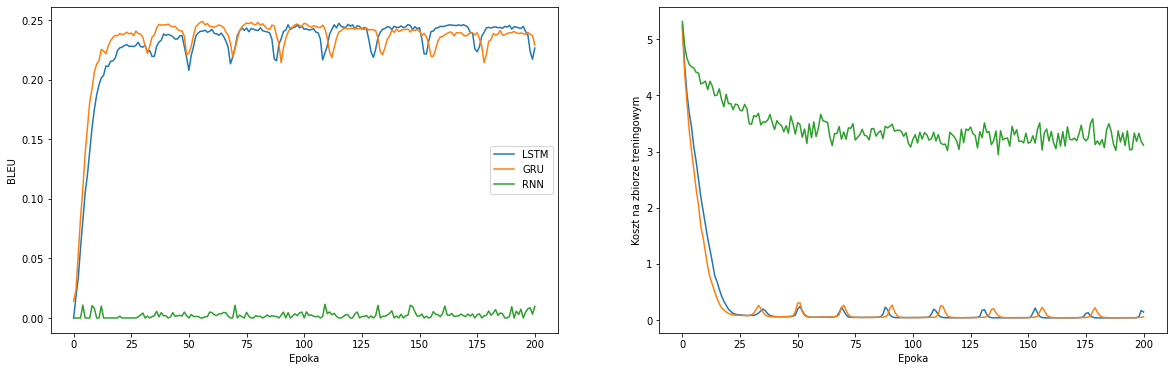

In [20]:
train_pairs, test_pairs, train_loader, test_loader = prepare_dataset(128)

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for key, item in results.items():
    bleus, losses, enc, dec = item

    # bleus, losses = result_dict["rnn_hs1024_es512_lr0.0001_bs256"]
    axes[0].plot(np.arange(201), bleus, label=key.upper())
    axes[0].set_xlabel("Epoka")
    axes[0].set_ylabel("BLEU")
    axes[0].legend()
    axes[1].plot(np.arange(201), losses)
    axes[1].set_xlabel("Epoka")
    axes[1].set_ylabel("Koszt na zbiorze treningowym")
    # translate_randomly(enc, dec, test_pairs, n=25)

# Atencja w RNN-ach

Zbudujemy teraz model Seq2Seq z mechanizmem atencji. W tym celu musimy zmienić tylko klasę reprezentującą dekoder.

In [21]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, rnn_cell_class, vocab_size, embedding_size, hidden_size):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)

        self.lstm = rnn_cell_class(
            embedding_size + hidden_size, self.hidden_size, batch_first=True
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, vocab_size),
        )

        self.alignment = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, input, hidden, targets=None, max_len=None, encoder_outputs=None):

        seq_att_weights = []
        outputs = []
        for idx in range(max_len):
            state = hidden[0] if isinstance(self.lstm, nn.LSTM) else hidden

            attended_encoder, att_weights = self.apply_attention(state, encoder_outputs)
            seq_att_weights += [att_weights]
            embedded = self.embedding(input)
            input = torch.cat([attended_encoder, embedded], dim=2)

            output, hidden = self.lstm(input, hidden)
            output = self.out(output)

            outputs += [output]
            if targets is not None:
                input = targets[:, idx].unsqueeze(-1)
            else:
                input = output.argmax(-1).detach()
        output = torch.cat(outputs, 1)
        seq_att_weights = torch.stack(seq_att_weights, 1)

        return output, seq_att_weights

    def apply_attention(self, hidden, encoder_outputs):
        hidden = hidden.transpose(0, 1).repeat(1, encoder_outputs.size(1), 1)
        concated = torch.cat([hidden, encoder_outputs], dim=2)
        alignments = self.alignment(concated)
        attention_weights = torch.softmax(alignments.squeeze(2), -1)

        attended_encoder = (encoder_outputs * attention_weights.unsqueeze(2)).sum(1)
        return attended_encoder.unsqueeze(1), attention_weights

In [ ]:
def train_attention_model(rnn_cell_class, embedding_size, hidden_size, lr, clipping):
    encoder = EncoderRNN(
        rnn_cell_class, input_lang.n_words, embedding_size, hidden_size
    ).to(device)
    decoder = AttnDecoderRNN(
        rnn_cell_class, output_lang.n_words, embedding_size, hidden_size
    ).to(device)
    return train(encoder, decoder, lr=lr, epochs_num=100, clipping=clipping)


att_results = {}
att_results["RNN"] = train_attention_model(nn.RNN, 1024, 1024, lr=0.0005, clipping=0.1)
att_results["GRU"] = train_attention_model(nn.GRU, 512, 1024, lr=0.0005, clipping=0.1)
att_results["LSTM"] = train_attention_model(
    nn.LSTM, 1024, 1024, lr=0.0005, clipping=0.1
)

Zwizualizujmy jakość poszczególnych modelów.

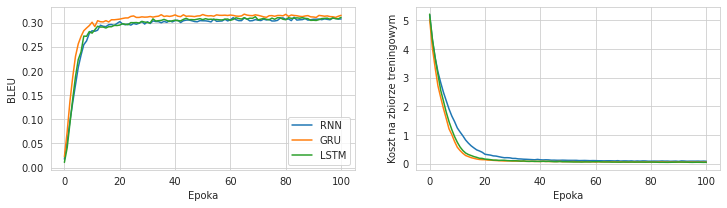

In [24]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

for key, item in att_results.items():
    bleus, losses, enc, dec = item

    # bleus, losses = result_dict["rnn_hs1024_es512_lr0.0001_bs256"]
    axes[0].plot(np.arange(101), bleus, label=key)
    axes[0].set_xlabel("Epoka")
    axes[0].set_ylabel("BLEU")
    axes[0].legend()
    axes[1].plot(np.arange(101), losses)
    axes[1].set_xlabel("Epoka")
    axes[1].set_ylabel("Koszt na zbiorze treningowym")